In [ ]:
#importing important libraries
from google.colab import files
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Creating List of filepaths for Training, Validation and Testing images.

train_dir = Path("/content/drive/MyDrive/Vegetable classification/Dataset/Vegetables/train")
train_filepath = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path("/content/drive/MyDrive/Vegetable classification/Dataset/Vegetables/test")
test_filepath = list(test_dir.glob(r'**/*.jpg'))

valid_dir = Path("/content/drive/MyDrive/Vegetable classification/Dataset/Vegetables/validation")
valid_filepath = list(valid_dir.glob(r'**/*.jpg'))

In [ ]:
#defining function to create Dataframe with filepaths and corresponding label.
def create_df(filepaths):

  labels = [str(filepaths[i]).split("/")[-2] for i in range(len(filepaths))]
  filepath = pd.Series(filepaths, name="Filepath").astype(str)
  labels = pd.Series(labels, name="Label")
  
  df = pd.concat([filepath,labels], axis=1)
  df = df.sample(frac=1).reset_index(drop=True)

  return df

In [ ]:
train_df = create_df(train_filepath)
valid_df = create_df(valid_filepath)
test_df = create_df(test_filepath)

In [ ]:
#printing training set info.
print("-------------Training set-----------------\n")
print(f"Number of images : {train_df.shape[0]}\n")
print(f"Number of different Vegetables : {len(train_df.Label.unique())}\n")
print(f"Vegetabels : {train_df.Label.unique()}")

-------------Training set-----------------

Number of images : 2042

Number of different Vegetables : 26

Vegetabels : ['bell pepper' 'chilli pepper' 'lettuce' 'soy beans' 'paprika' 'carrot'
 'raddish' 'cabbage' 'eggplant' 'cauliflower' 'sweetcorn' 'cucumber'
 'garlic' 'onion' 'capsicum' 'tomato' 'lemon' 'beetroot' 'turnip' 'peas'
 'ginger' 'jalepeno' 'spinach' 'corn' 'potato' 'sweetpotato']


In [ ]:
#Display the training Dataframe
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Vegetable classificatio...,bell pepper
1,/content/drive/MyDrive/Vegetable classificatio...,chilli pepper
2,/content/drive/MyDrive/Vegetable classificatio...,lettuce
3,/content/drive/MyDrive/Vegetable classificatio...,soy beans
4,/content/drive/MyDrive/Vegetable classificatio...,paprika


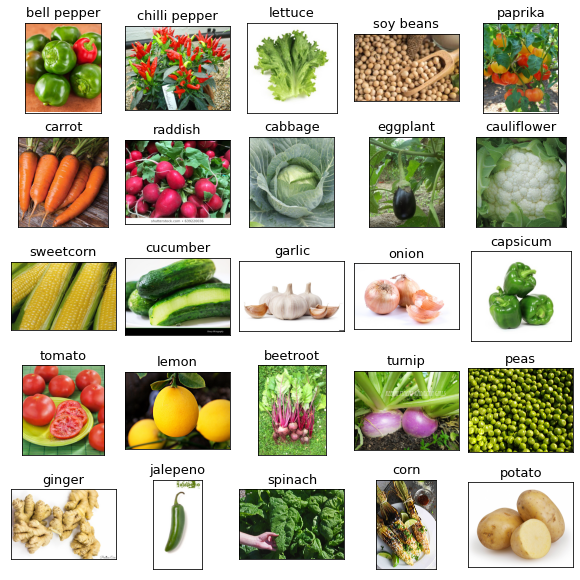

In [ ]:
#Creating dataframe with unique vegetable label to display images
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

#Display some images of the dataset
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.Filepath[i]))
  ax.set_title(df_unique.Label[i], fontsize=13)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
#Defining Data Generator for training and testing set

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
#Augmenting Images using Data Generator

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size = (224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_images = train_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col="Filepath",
    y_col="Label",
    target_size = (224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepath",
    y_col="Label",
    target_size = (224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)

Found 2042 validated image filenames belonging to 26 classes.
Found 241 validated image filenames belonging to 26 classes.
Found 241 validated image filenames belonging to 26 classes.


In [ ]:
#Loading the pretrained model  Mobilenet_V2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
#Lets Train the model

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(26, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_images,
    validation_data=valid_images,
    batch_size=32,
    epochs=7,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=2,
                   restore_best_weights=True
               )
    ]
)

Epoch 1/7
16/64 [======>.......................] - ETA: 16:07 - loss: 2.8024 - accuracy: 0.2422

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


64/64 [==============================] - 1412s 22s/step - loss: 1.5869 - accuracy: 0.5558 - val_loss: 0.4034 - val_accuracy: 0.8589
Epoch 2/7
64/64 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.8247

In [ ]:
#Save model
import datetime
model.save("/content/drive/MyDrive/Vegetable classification/Models/mymodel2.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Vegetable classification/Models/mymodel2.h5")

In [ ]:
#plotting graphs for evaluation

epochs = np.arange(1,8)
history_df = pd.DataFrame(history.history)

history_df[['accuracy', "val_accuracy"]].plot()
plt.title("Accuracy")
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.show()


epochs = np.arange(1,8)
history_df = pd.DataFrame(history.history)

history_df[['loss', "val_loss"]].plot()
plt.title("Loss")
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.show()

In [ ]:
#predicting labels on test set
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

#mapping the label
labels = (train_images.class_indices)
labels = dict((v,l) for l,v in labels.items())

pred = [labels[v] for v in pred]
y_test = [labels[v] for v in test_images.classes]

In [ ]:
#Lets check Accuracy and F1 score on test data
Accuracy = accuracy_score(y_test, pred)

print(f"Accuracy of the model on test data is : {Accuracy*100:.2f}%\n")

In [ ]:
mat = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(15,10))
sns.heatmap(mat,
            annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test))
            )
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
#Display some images of the dataset with their labels and predictions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
  ax.set_title(f"True : {test_df.Label.iloc[i]}\n Predicted : {pred[i]}")

plt.tight_layout()
plt.show()

In [ ]:
label_dict={0: 'beetroot',
 1: 'bell pepper',
 2: 'cabbage',
 3: 'capsicum',
 4: 'carrot',
 5: 'cauliflower',
 6: 'chilli pepper',
 7: 'corn',
 8: 'cucumber',
 9: 'eggplant',
 10: 'garlic',
 11: 'ginger',
 12: 'jalepeno',
 13: 'lemon',
 14: 'lettuce',
 15: 'onion',
 16: 'paprika',
 17: 'peas',
 18: 'potato',
 19: 'raddish',
 20: 'soy beans',
 21: 'spinach',
 22: 'sweetcorn',
 23: 'sweetpotato',
 24: 'tomato',
 25: 'turnip'}

In [ ]:
def process_image(image_path):
  """
  Take an image file path, image size and turns the image into a Tensor.
  """

  #Read in an image file
  image = tf.io.read_file(image_path)
  
  #Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green and Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  #Convert the color channel value from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[224,224])

  image = tf.expand_dims(image, 0)

  return image

In [ ]:
uploaded_image = files.upload()

In [ ]:
path = "/content/drive/MyDrive/Vegetable classification/Dataset/Vegetables/20220316_210134.jpg"
image = process_image(path)
pred = model.predict(image)
pred_image = label_dict[np.argmax(pred)]
plt.imshow(plt.imread(path))
print(pred_image)